## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df.query('converted==1').shape[0]/df.shape[0]

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" & landing_page != "new_page"').shape[0] + df.query('group != "treatment" & landing_page == "new_page"').shape[0]

3893

Do any of the rows have missing values?

In [7]:
df.info() # there is no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [8]:
df2=df.drop(df[((df['group'] == "treatment") & (df['landing_page'] != "new_page")) | ((df['group'] == "control") & (df['landing_page'] != "old_page"))].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2.drop_duplicates(subset=['user_id'], inplace=True)

What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
ctrl_conv = df2.query('group=="control"')['converted'].mean()
ctrl_conv

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treat_conv = df2.query('group=="treatment"')['converted'].mean()
treat_conv

0.11880806551510564

In [17]:
obs_diff = treat_conv - ctrl_conv
obs_diff # we will need that later

-0.0015782389853555567

What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

There is no sufficient evidence to say that the new treatment page leads to more conversions. We can see the probability of conversion in the control group is 0.1203863045004612 and in the treatment group 0.11880806551510564, it's not big of a difference.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  


For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} \leq p_{old}$$

$$H_1: p_{new} > p_{old}$$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old=df['converted'].mean()
p_old

0.11965919355605512

What is $n_{new}$?

In [21]:
n_new=df2.query('landing_page=="new_page"').shape[0]
n_new

145310

What is $n_{old}$?

In [22]:
n_old=df2.query('landing_page=="old_page"').shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1], size = n_old, p=[1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Find $p_{new}$ - $p_{old}$ for our simulated values.

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0006972067212416833

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated.

In [26]:
n_new_sample_means=np.random.binomial(n_new, p_new, 10000)/n_new
n_old_sample_means=np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs=n_new_sample_means - n_old_sample_means
p_diffs=np.array(p_diffs)
p_diffs

array([ 1.21621222e-03, -5.04382215e-04, -5.38968768e-04, ...,
       -2.56929199e-03,  2.53778288e-05,  1.15424838e-03])

Plot a histogram of the **p_diffs**.

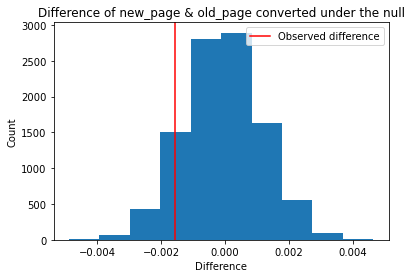

In [27]:
plt.hist(p_diffs)
plt.title('Difference of new_page & old_page converted under the null')
plt.xlabel('Difference')
plt.ylabel('Count')

plt.axvline(obs_diff, c='red', label='Observed difference')
plt.legend();

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs>obs_diff).mean() # p-value

0.8957

This value is called p-value in scientific studies, if this value is higher than Type I Error rate of 5% then there is no difference between the new and old pages (Null Hypothesis), otherwise there is a difference (Alternative Hypothesis).

We have a p-value of 0.8957 (higher than 0.05), so we don't have evidence that there is actually a difference, in otherwords we fail to reject the Null Hypothesis and we will keep the old page.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" & converted==1').shape[0]
convert_new = df2.query('landing_page=="new_page" & converted==1').shape[0]
n_old = df2.query('landing_page=="old_page"').shape[0]
n_new = df2.query('landing_page=="new_page"').shape[0]

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [31]:
from scipy.stats import norm

norm.ppf(0.95) # the critical value at 95% confidence interval for one-sided test

1.6448536269514722

The z-score represents the distance between the two converted success rates in terms of the standard error.

We can see that $Z_{score}$ > $Z_{0.05}$ in this right-tailed test, therefore we fail to reject the Null Hypothesis.

Also the p-value is higher than Type I Error rate (Significance Level), which means we fail to reject the Null Hypothesis and we will keep the old page.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.

Logistic Regression will be performed, because the predicted column is categorical.

The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  We need to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept']=1
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.drop('control', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
logit_mod=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-07-25 23:25 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [35]:
np.exp(result.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

- p-value = 0.1899

- p-value here differs from Part II because in Part II it was one-tailed but in this Logistic Regression it's two tailed.

**Hypothesis:**

$$H_0: p_{new}=p_{old}$$

$$H_1: p_{new}≠p_{old}$$

**Coefficients explaination:**
- We predict the conversion rate in the control group to be 0.136863 .

- The conversion rate in treatment group is predicted to be 0.985123 times less than the conversion rate in control group.

We need to make sure the model is accurate as much as possible, adding more factors to consider might help to increase accuracy. But in some cases it also has a disadvantages for example adding too many factors without any theoretical justification may result in an over-fit model or even multicollinearity.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion? 

In [36]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.drop(['country'], axis=1, inplace=True)
logit_mod=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])
result=logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-07-25 23:25 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [40]:
np.exp(result.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

**In this model:**

- Small p-value (< 0.05) means the variable is statistically significant in relating to the response variable, so all variables are not statistically significant.

- We predict the control group in US to have a conversion rate of 0.136795 .

- The conversion rate in treatment group from all countries is predicted to be 0.985168 times less than the conversion rate in control group from US holding all other variables constant.

- The conversion rate in treatment group from CA is predicted to be 0.960062 times less than the conversion rate in control group from US holding all other variables constant.

- The conversion rate in treatment group from UK is predicted to be 1.009932 times higher than the conversion rate in control group from US holding all other variables constant.

Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
df_new['CA_ab_page']=df_new['ab_page'] * df_new['CA']
df_new['UK_ab_page']=df_new['ab_page'] * df_new['UK']
df_new.head()

,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [42]:
### Fit Your Logistic Model And Obtain the Results
logit_mod=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA_ab_page','UK_ab_page','CA','UK']])
result=logit_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-07-25 23:25 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
==================================================================

"""

In [43]:
np.exp(result.params)

intercept     0.137178
ab_page       0.979646
CA_ab_page    0.954198
UK_ab_page    1.031896
CA            0.982625
UK            0.994272
dtype: float64

**In this model:**

All p-values are higher than 0.05, so we can say that the interactions between ab_page and countries have no significant effects on conversion rate.

<a id='conclusions'></a>
## Conclusions

From the whole study, we don't have sufficient evidence that the new page has a higher conversion rate than the old one, therefore we suggest that we keep the old page.

There could be additional variables that might change our conclusions, for example the amount of time the user stayed on the site (in seconds) or time of the day (whether it's night, morning, midday or afternoon).